# <span style="color:green"> Laboratorio di simulazione numerica (LSN) </span>
## <span style="color:blue">  Esercitazione numerica 8 </span>

## Moduli
Si importano moduli e librerie utili per il notebook. Inoltre si inizializzano i parametri di matplotlib.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams["legend.loc"] = 'best'

## Esercizio 08.2: <span style="color:brown"> Monte Carlo Variazionale (VMC) </span>
Si utilizza una tecnica di tipo Monte Carlo variazionale per simulare una particella quantistica unidimensionale posta nel seguente potenziale:

$$
V(x) = x^4 - \frac{5}{2}x^2
$$

Questo metodo utilizza una funzione d'onda di prova, che dipende da alcuni parametri che devono essere ottimizati per ottenere l'effettivo stato fondamentale. Nel seguito si utilizzerà la seguente funzione di prova (simmetrica, dato che il problema è simmetrico):

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+ e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

in cui i due parametri variazionali da ottimizzare sonola media $\mu$ e la deviazione standard $\sigma$.\
Attraverso varie esecuzioni del programma è stato possibile trovare che i valori ottimizzati dei parametri sono: $\mu=0.81$ e $\sigma=0.6$.

A questo punto è stata eseguita unasimulazione con i parametri ottimizzati ed è stao possibile ricavare la il valor medio del hamiltoniana $\langle {\hat H} \rangle_T$ sulla funzione d'onda trial, che approssima il ground state. Questa simulazione è stata divisa in $N=50$ blocchi, con $L=10000$ steps per ogni blocco; medie ed errori sono calcolate utilizzando il data blocking.

In [2]:
#functions
def analytic_sol(x, mu, sigma):
    Zm = (x - mu)/sigma;
    Zp = (x + mu)/sigma;
    norm = 2.*np.sqrt(np.pi)*sigma*(1 + np.exp(-(mu/sigma)**2))
    
    return ( np.exp(-Zm**2) + np.exp(-Zp**2) + 2.*np.exp(-(x**2 + mu**2)/(sigma**2)) ) / norm

def Vpot(x):
    return (x**2 - 2.5)*(x**2)

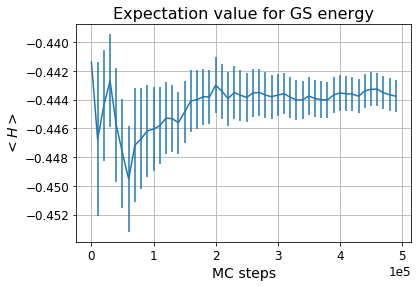

In [3]:
#load data
steps, ave_H, err_H = np.loadtxt('QMC_1D/ave_H.dat', dtype=float, unpack='true')
L = 10000  #steps per block
steps *= L

plt.errorbar(steps, ave_H, yerr=err_H)
plt.ticklabel_format(axis='x', style='sci',scilimits=(0,0))
plt.title(f'Expectation value for GS energy', size=16)
plt.xlabel(f'MC steps')
plt.ylabel(f'$<H>$')
plt.grid(True)
plt.show()

### Distribuzione di probabilità

Si mostra la ditribuzione di probabilità $|\Psi_T(x)|^2$ campionata con l'algoritmo di Metropolis e la si confronta con la curva analitica. Inoltre si vuole fare un confronto tra le soluzioni ottenute con il Monte Carlo e quella che può essere ottenuta con un altro metodo numerico (trasformazione dell'equazione di Schroedinger in un'equazione matriciale).

In [4]:
#load sample vector
sample = np.loadtxt('QMC_1D/sample_trial.dat', dtype=float)
mu = 0.81   #optimized mean
sigma = 0.6 #optimized stddev
#delta_metro = 2.3

#matrix method
hbar = 1.
m = 1.
a = 5.
N = 1000 #number of iterations

x = np.linspace(-a/2, a/2, N)
psi = analytic_sol(x, mu, sigma)
V = Vpot(x)
dx = x[1] - x[0] #step size

#The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)

#Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

#Compute eigenvectors and their eigenvalues
E, psi_CDM = np.linalg.eigh(H)

# Take the transpose & normalize
psi_CDM = np.transpose(psi_CDM)
psi_CDM = psi_CDM/np.sqrt(dx)

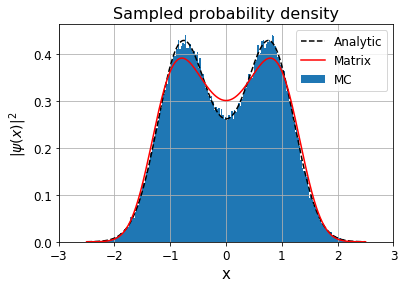

In [5]:
#fill histogram with |psi(x)|^2
plt.hist(sample, bins=200, density=True, label='MC')
plt.plot(x, psi,'k', linestyle='--', linewidth=1.5, label='Analytic')
plt.plot(x,(psi_CDM[0])**2, color='red', label='Matrix')
plt.title(f'Sampled probability density')
plt.xlabel(f'x', size=15)
plt.ylabel('$|\psi (x)|^2$')
plt.xlim(-3,3)
plt.legend()
plt.grid(True)
plt.show()

Si osserva che la distribuzione campionata e la soluzione analitica sono diverse dalla soluzione che si ottiene con la matrice: questo perchè probabilmente la funzione d'onda del ground state di questo problema non è data dalla somma di due gaussiane.

## Esercizio 08.3: <span style="color:brown"> Path Integral Monte Carlo (PIMC) e Path Integral Ground State (PIGS) </span>
Si vogliono utilizzare due metodi numerici diversi, rispetto a quelli dell'esercizio precedente, per poter stimare la funzione d'onda dello stato fondamentale e calcolarne l'energia.\
Per prima cosa si utilizza un algoritmo di tipo *Path Integral Monte Carlo*  (PIMC), che opera a temperatura nulla ($T=0$) e si vogliono far proiettare sul ground state del problema due funzioni: una funzione costante $\Psi_T(x)=1$ e la $\Psi_T(x)=\Psi_T^{\sigma,\mu}(x)$ ottimizzata nell'esercizio precedente.\
Utilizzando questi risultati si potrà fare un confronto con quelli ottenuti ai punti precedenti.

### Temperatura nulla: PIGS 

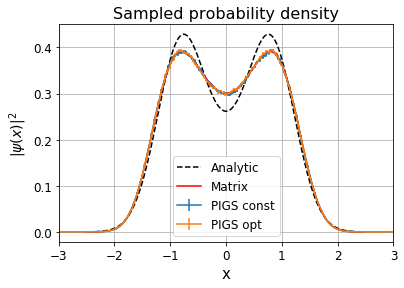

In [6]:
#load data for PIGS simulations
steps, prob, err_prob = np.loadtxt('QMC_1D/probability_pigs.dat', dtype=float, unpack='true')
steps_psi, prob_psi, err_prob_psi = np.loadtxt('QMC_1D/probability_pigs_psi.dat', dtype=float, unpack='true')


plt.errorbar(steps, prob, yerr=err_prob, label='PIGS const')
plt.errorbar(steps_psi, prob_psi, yerr=err_prob_psi, label='PIGS opt')
plt.plot(x, psi,'k', linestyle='--', linewidth=1.5, label='Analytic')
plt.plot(x,(psi_CDM[0])**2, color='red', label='Matrix')
plt.title(f'Sampled probability density')
plt.xlabel(f'x', size=15)
plt.ylabel('$|\psi (x)|^2$')
plt.xlim(-3,3)
plt.legend()
plt.grid(True)
plt.show()

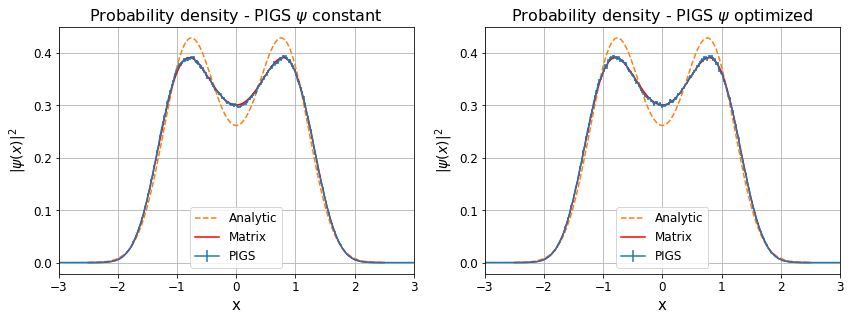

In [7]:
#compare densities
fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)

#PIGS constant
ax1.errorbar(steps, prob, yerr=err_prob, label='PIGS')
ax1.plot(x, psi, linestyle='--', linewidth=1.5, label='Analytic')
ax1.plot(x,(psi_CDM[0])**2, color='red', label='Matrix')
ax1.set_title(f'Probability density - PIGS $\psi$ constant')
ax1.set_xlabel(f'x', size=15)
ax1.set_ylabel('$|\psi (x)|^2$')
ax1.set_xlim(-3,3)
ax1.legend(loc='lower center')
ax1.grid(True)

#PIGS optimized psi
plt.errorbar(steps_psi, prob_psi, yerr=err_prob_psi, label='PIGS')
ax2.plot(x, psi, linestyle='--', linewidth=1.5, label='Analytic')
ax2.plot(x,(psi_CDM[0])**2, color='red', label='Matrix')
ax2.set_title(f'Probability density - PIGS $\psi$ optimized')
ax2.set_xlabel(f'x', size=15)
ax2.set_ylabel('$|\psi (x)|^2$')
ax2.set_xlim(-3,3)
ax2.legend(loc='lower center')
ax2.grid(True)

Si nota che la soluzione ottenuta con il metodo PIGS è la stessa che sia nel caso della funzione costante che della funzione ottimizzata; questo è ragionevole dato che l'agoritmo proietta iterativamente la funzione di prova sullo stato fondamentale, fino ad ottenere  l'esatta funzione del ground state del sistema. Tuttavia il tempo che si impiega a proiettare la funzione ottimizzata è molto minore (circa la metà dei tempi immaginari necessari per la funzione costante), dato che essa è già stata ripulita da molti stati eccitati.\
Si vede che questi risultati sono gli stessi che si ottengono con il metodo matriciale e quindi differiscono da quelli del campionamento con l'algoritmo di Metropolis.

Utilizzando l'algoritmo PIGS è possibile eseguire un confronto anche con le energie per lo stato fondamenale che si sono ottenute con i metodi predecenti.\
I risultati vengono riportati sotto forma di grafico e confrontati.

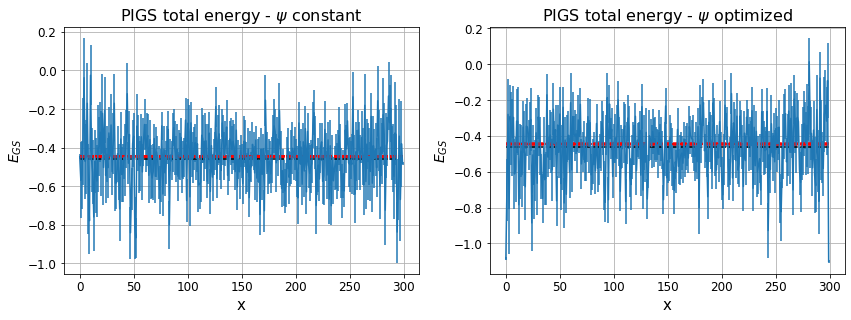

In [8]:
#compare energies
step, kin, err_kin = np.loadtxt('QMC_1D/kinetic_pigs.dat', dtype=float, unpack='true')
step, pot, err_pot = np.loadtxt('QMC_1D/potential_pigs.dat', dtype=float, unpack='true')
step_psi, kin_psi, err_kin_psi = np.loadtxt('QMC_1D/kinetic_pigs_psi.dat', dtype=float, unpack='true')
step_psi, pot_psi, err_pot_psi = np.loadtxt('QMC_1D/potential_pigs_psi.dat', dtype=float, unpack='true')
err_E = np.sqrt(err_pot**2 + err_kin**2)
err_E_psi = np.sqrt(err_pot_psi**2 + err_kin_psi**2)

#make plot for GS energy
fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)

#PIMC constant
ax1.errorbar(step, pot + kin, yerr=err_E)
ax1.hlines(y=ave_H, xmin=0, xmax=step[-1], linestyles='dashed', color='red')
ax1.hlines(y=E[0], xmin=0, xmax=step[-1], linestyles='dashed', color='black')
ax1.set_title(f'PIGS total energy - $\psi$ constant')
ax1.set_xlabel(f'x', size=15)
ax1.set_ylabel('$E_{GS}$')
ax1.grid(True)

#PIMC optimized psi
ax2.errorbar(step_psi, pot_psi + kin_psi, yerr=err_E_psi)
ax2.hlines(y=ave_H, xmin=0, xmax=step[-1], linestyles='dashed', color='red')
ax2.hlines(y=E[0], xmin=0, xmax=step[-1], linestyles='dashed', color='black')
ax2.set_title(f'PIGS total energy - $\psi$ optimized')
ax2.set_xlabel(f'x', size=15)
ax2.set_ylabel('$E_{GS}$')
ax2.grid(True)

Si vede che i risultati dei punti precedenti sono pienamente compatibili con quelli ottenuti con questa tecnica numerica.

### Temperatura finita: PIMC
Si vogliono confrontare le densità di probabilità che si ottengono utilizzando l'algoritmo PIMC con quelle trovate nei passaggi precedenti. Dato che la temperatura non è più nulla, il sistema può accedere anche a stati eccitati e di conseguenza queste densità di probabilità saranno delle combinazioni di funzioni d'onda dei vari stati del sistema.\
Per eseguire queste simulazioni sono state scelte 3 temperature: $T=1.25$, $T=2.5$, $T=5$.

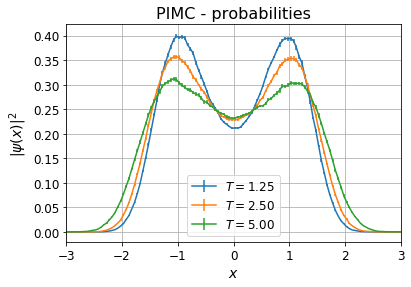

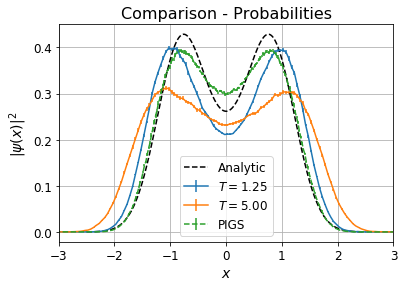

In [9]:
#load probability sampled with PIMC code. T = 1.25, 2.5, 5 
steps_1, prob_1, err_prob_1 = np.loadtxt('QMC_1D/probability_1.dat', dtype=float, unpack='true')
steps_2, prob_2, err_prob_2 = np.loadtxt('QMC_1D/probability_2.dat', dtype=float, unpack='true')
steps_5, prob_5, err_prob_5 = np.loadtxt('QMC_1D/probability_5.dat', dtype=float, unpack='true')

#make plot for comparison
plt.errorbar(steps_1, prob_1, yerr=err_prob_1, label='$T = 1.25$')
plt.errorbar(steps_2, prob_2, yerr=err_prob_2, label='$T = 2.50$')
plt.errorbar(steps_5, prob_5, yerr=err_prob_5, label='$T = 5.00$')
plt.title(f'PIMC - probabilities', size=16)
plt.xlabel(f'$x$')
plt.ylabel(f'$|\psi (x)|^2$')
plt.xlim(-3,3)
plt.legend()
plt.grid(True)
plt.show()

#compare PIMS with PIGS and Metropolis
plt.errorbar(steps_1, prob_1, yerr=err_prob_1, label='$T = 1.25$')
plt.errorbar(steps_5, prob_5, yerr=err_prob_5, label='$T = 5.00$')
plt.errorbar(steps_psi, prob_psi, yerr=err_prob_psi, linestyle='--', label='PIGS')
plt.plot(x, psi, 'k', linestyle='--', linewidth=1.5, label='Analytic')
plt.title(f'Comparison - Probabilities', size=16)
plt.xlabel(f'$x$')
plt.ylabel(f'$|\psi (x)|^2$')
plt.xlim(-3,3)
plt.legend()
plt.grid(True)
plt.show()